### Importing required libraries

In [2]:
import pandas as pd
import numpy as np

### Loading the provided dataset

In [3]:
df = pd.read_excel("Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Inspecting the dataset

In [4]:
#shape tell how many rows and columns are in the dataset
df.shape

(541909, 8)

In [5]:
#this tell all the information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
#this tells the number missing value in each column
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
#this tells percentage of missing values in each column
df.isnull().sum()/len(df) *100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [8]:
#this tell what are the distinct countries present in the dataset
df['Country'].nunique()

38

### Data Cleaning

In [9]:
#we have to do customer segmentation so the rows without customerID is useless so this line drops all the rows with missing customerId
df.dropna(subset=['CustomerID'], inplace=True)

In [10]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

the above output show we have managed all the missing values

In [11]:
#this will remove all the orders where the quantity is less than 0, becuase the quantity can't be less than 0
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

In [12]:
#this will change the datatype of customerId to int
df['CustomerID'] = df['CustomerID'].astype(int)

In [13]:
#this will help in resetting the index of the dataset
df.reset_index(drop=True, inplace=True)

In [14]:
df.shape

(397884, 8)

now the dataset is cleaned and ready for feature engineering

### Featuring Engineering

Now we'll calculate Recency, Frequency, Monetary

Recency - This tells us how recently a customer has purchased(days since last purchase has done by the customer).

Frequency - How often the customer has purchased.

Monetary - This tell how much money the customer has spent.

In [15]:
import datetime as dt
reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Quantity': lambda x: (x * df.loc[x.index, 'UnitPrice']).sum()
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


###  Normalizing rmf

Why normalizing rmf is necessary?

Because right now the recency, frequency and monetary are on very different scales, monetary is very large as compared to others in the table so, if we don't normalize or standardize rmf, K means use euclidean distance, so monetary will dominate.

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(rfm)

rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

rfm_scaled.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,2.334574,-0.425097,8.358668
12347,-0.905340,0.354417,0.250966
12348,-0.175360,-0.035340,-0.028596
12349,-0.735345,-0.425097,-0.033012
12350,2.174578,-0.425097,-0.191347


### Elbow method to determine the optimal number of clusters(k)

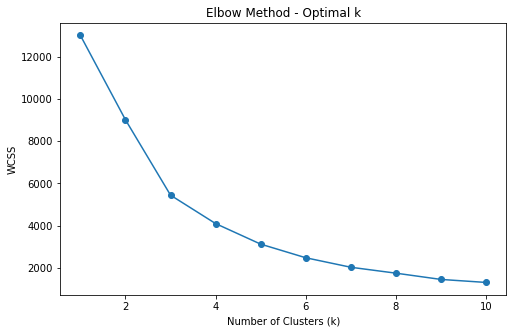

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []  # within-cluster sum of squares

# Try k values from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ = WCSS

# Plot the elbow curve
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method - Optimal k")
plt.show()

Going to use k means with 4 clusters, according to the above elbow plot.

In [18]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(rfm_scaled)

rfm['Cluster'] = kmeans.labels_

rfm.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346,326,1,77183.60,3
12347,2,7,4310.00,0
12348,75,4,1797.24,0
12349,19,1,1757.55,0
12350,310,1,334.40,1


In [19]:
# Cluster profiling
cluster_profile = rfm.groupby('Cluster').mean()[['Recency', 'Frequency', 'Monetary']]
cluster_profile['Count'] = rfm['Cluster'].value_counts()

cluster_profile

,Recency,Frequency,Monetary,Count
Cluster,,,,
0,43.702685,3.682711,1359.049284,3054
1,248.075914,1.552015,480.617480,1067
2,7.384615,82.538462,127338.313846,13
3,15.500000,22.333333,12709.090490,204


### Cluster Profiling Interpretation

Cluster 0 – “Active but Low Value Customers”

    Recency ~ 44 days → they purchased relatively recently.

    Frequency ~ 3.7 → they buy occasionally.

    Monetary ~ 1359 → they spend small amounts.

Cluster 1 – “Inactive Customers”

    Recency ~ 248 days → last purchase was long ago.

    Frequency ~ 1.5 → very few purchases.

    Monetary ~ 480 → very low spend.

Cluster 2 – “VIP Customers”

    Recency ~ 7 days → extremely recent.

    Frequency ~ 82 → they buy a lot.

    Monetary ~ 127k → extremely high spenders.
    
Cluster 3 – “Loyal Customers”

    Recency ~ 15 days → recent buyers.

    Frequency ~ 22 → very frequent buyers.

    Monetary ~ 12k → very high spenders.

In [20]:
# now adding the clusters labels to the original dataset
df_with_clusters = df.merge(
    rfm[['Cluster']],  # only Cluster column from RFM
    left_on='CustomerID',
    right_index=True,
    how='left'
)

df_with_clusters.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,3
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,3
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,3
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,3
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,3


In [36]:
#this line will tell how many customers comes under each cluster
df_with_clusters['Cluster'].value_counts().sort_index()

0    255959
1     30623
2     28480
3     82822
Name: Cluster, dtype: int64

### Visualizations

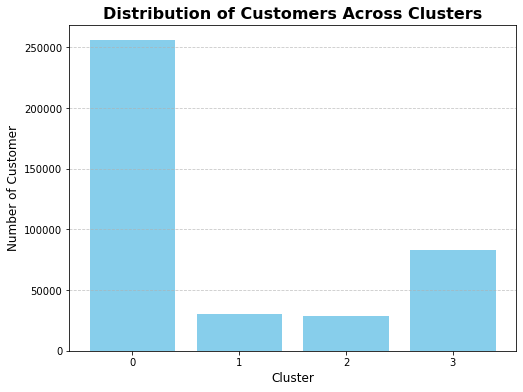

In [35]:
import matplotlib.pyplot as plt
cluster_counts = df_with_clusters['Cluster'].value_counts().sort_index()
cluster_ids = cluster_counts.index.astype(str)
row_counts = cluster_counts.values


plt.figure(figsize=(8, 6))

plt.bar(cluster_ids, row_counts, color='skyblue')

plt.title('Distribution of Customers Across Clusters', fontsize=16, weight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Customer', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

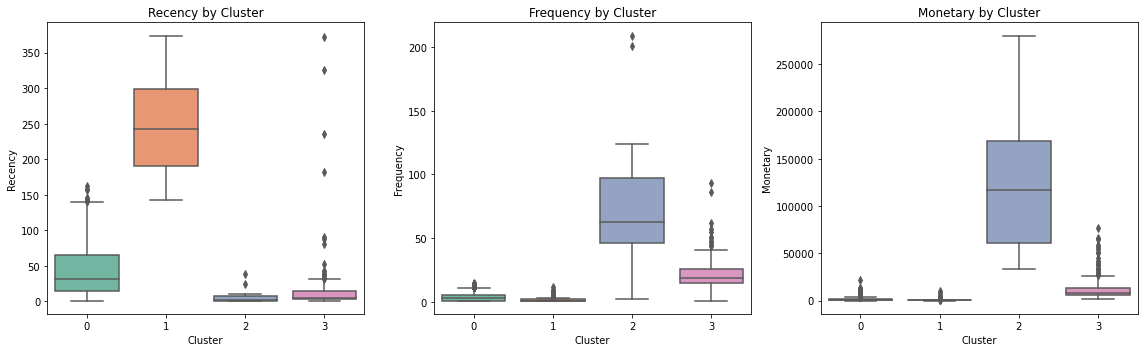

In [28]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster', y='Recency', data=rfm.reset_index(), palette='Set2')
plt.title("Recency by Cluster")

plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster', y='Frequency', data=rfm.reset_index(), palette='Set2')
plt.title("Frequency by Cluster")

plt.subplot(1, 3, 3)
sns.boxplot(x='Cluster', y='Monetary', data=rfm.reset_index(), palette='Set2')
plt.title("Monetary by Cluster")

plt.tight_layout()
plt.show()

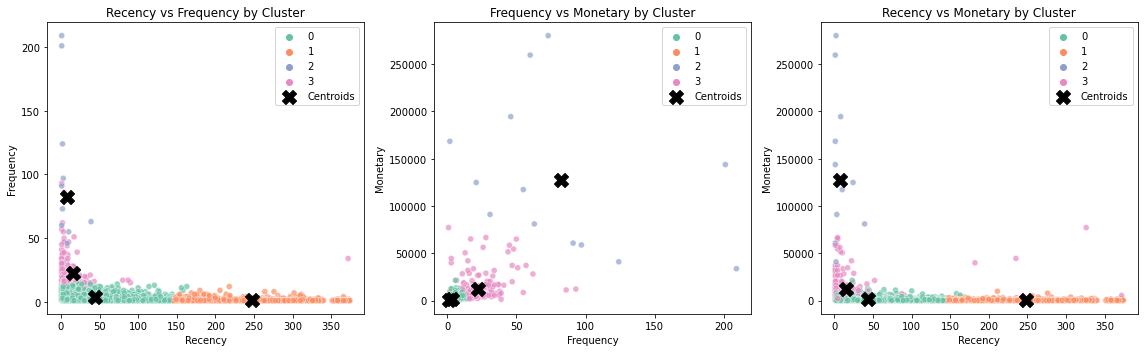

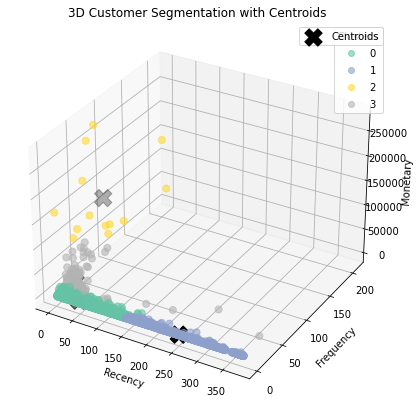

In [29]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

centroids = kmeans.cluster_centers_

centroids_original = scaler.inverse_transform(centroids)

centroids_df = pd.DataFrame(
    centroids_original,
    columns=['Recency', 'Frequency', 'Monetary']
)
centroids_df['Cluster'] = range(len(centroids_df))


plt.figure(figsize=(16, 5))

# Recency vs Frequency
plt.subplot(1, 3, 1)
sns.scatterplot(
    data=rfm.reset_index(),
    x='Recency', y='Frequency',
    hue='Cluster', palette='Set2', alpha=0.7
)
plt.scatter(
    centroids_df['Recency'], centroids_df['Frequency'],
    color='black', marker='X', s=200, label='Centroids'
)
plt.title("Recency vs Frequency by Cluster")
plt.legend()

# Frequency vs Monetary
plt.subplot(1, 3, 2)
sns.scatterplot(
    data=rfm.reset_index(),
    x='Frequency', y='Monetary',
    hue='Cluster', palette='Set2', alpha=0.7
)
plt.scatter(
    centroids_df['Frequency'], centroids_df['Monetary'],
    color='black', marker='X', s=200, label='Centroids'
)
plt.title("Frequency vs Monetary by Cluster")
plt.legend()

# Recency vs Monetary
plt.subplot(1, 3, 3)
sns.scatterplot(
    data=rfm.reset_index(),
    x='Recency', y='Monetary',
    hue='Cluster', palette='Set2', alpha=0.7
)
plt.scatter(
    centroids_df['Recency'], centroids_df['Monetary'],
    color='black', marker='X', s=200, label='Centroids'
)
plt.title("Recency vs Monetary by Cluster")
plt.legend()

plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    rfm['Recency'], rfm['Frequency'], rfm['Monetary'],
    c=rfm['Cluster'], cmap='Set2', s=50, alpha=0.6
)

ax.scatter(
    centroids_df['Recency'], centroids_df['Frequency'], centroids_df['Monetary'],
    color='black', marker='X', s=300, label='Centroids'
)

ax.set_title("3D Customer Segmentation with Centroids")
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters", loc="upper right")
ax.add_artist(legend1)
ax.legend()

plt.show()